# Exploring Structure in Chinese Noun Embeddings

---

This project investigates how Chinese nouns organise in BERT’s embedding space, using clustering and dimensionality reduction to uncover underlying linguistic patterns. 

The goal was to explore whether semantic categories emerge naturally from contextual embeddings, and to what extent structural properties of Chinese, such as single-character morphology, influence the organisation of meaning.  

---

This notebook uses the [**SUBTLEX-CH**](http://www.ugent.be/pp/experimentele-psychologie/en/research/documents/subtlexch) subtitle corpus for Chinese word frequencies. The raw files are not tracked in git, but the pre-processed `nouns_top2500.csv` is included.

**To regenerate from scratch:**
1. Download `SUBTLEX-CH-WF_PoS.xlsx` from [**SUBTLEX-CH**](http://www.ugent.be/pp/experimentele-psychologie/en/research/documents/subtlexch) and place in the `data/` directory
3. Delete `data/nouns_top2500.csv`
4. Run the cells below

## Data Preparation

### Load Data

In [2]:
import pandas as pd
import os

# Load from existing CSV if available
if os.path.exists('data/nouns_top2500.csv'):
    print("Loading existing nouns_top2500.csv...")
    df_noun_top2500 = pd.read_csv('data/nouns_top2500.csv')
else:
    # Process from source XLSX file
    print("Processing SUBTLEX-CH-WF_PoS.xlsx to create nouns_top2500.csv...")
    df_pos = pd.read_excel('data/SUBTLEX-CH-WF_PoS.xlsx', skiprows=2)
    df_pos.columns = ['Lemma', 'WF_Lemma', 'WordForm', 'PoS', 'WF_PoS']

    df_noun = df_pos[df_pos['PoS'] == 'n']
    df_noun = df_noun.drop(columns=['PoS', 'Lemma', 'WF_Lemma'])
    df_noun = df_noun.sort_values('WF_PoS', ascending=False)

    df_noun_top2500 = df_noun.head(2500)
    df_noun_top2500 = df_noun_top2500.rename(columns={'WordForm': 'Noun'})
    df_noun_top2500 = df_noun_top2500.rename(columns={'WF_PoS': 'Frequency'})
    
    df_noun_top2500.to_csv('data/nouns_top2500.csv', index=False)
    print("Created and saved nouns_top2500.csv")

print(f"Loaded {len(df_noun_top2500)} nouns")

Loading existing nouns_top2500.csv...
Loaded 2500 nouns


### Add Translations

In [3]:
from deep_translator import GoogleTranslator
import time

df_noun_top2500 = pd.read_csv('data/nouns_top2500.csv')
translator = GoogleTranslator(source='zh-CN', target='en')

def get_english_equivalent(word):
    try:
        translation = translator.translate(word)
        return translation.strip().lower()
    except Exception as e:
        print(f"Error translating {word}: {e}")
        return 'N/A'

if 'English' not in df_noun_top2500.columns:
    df_noun_top2500['English'] = ''

translated_count = 0
for i, row in df_noun_top2500.iterrows():

    if pd.notna(row['English']) and row['English'] != '':
        continue
    
    word = row['Noun']
    equivalent = get_english_equivalent(word)
    df_noun_top2500.at[i, 'English'] = equivalent
    translated_count += 1
    
    time.sleep(0.1)

    if translated_count % 100 == 0:
        print(f"Translated {translated_count} words...")

print(f"Total words translated: {translated_count}/{len(df_noun_top2500)}\n")

df_noun_top2500.to_csv('data/nouns_top2500.csv', index=False)
print(df_noun_top2500.head(10))

Total words translated: 0/2500

  Noun  Frequency    English
0    人   194914.0     people
1    事    97710.0      thing
2   时候    52176.0       when
3   先生    46864.0  gentlemen
4    话    39887.0       talk
5   东西    37700.0      thing
6   孩子    37243.0      child
7   问题    33364.0   question
8   时间    30703.0       time
9    钱    29217.0      money


### Define Helper Functions

In [4]:
def find_representative_nouns(embeddings, labels, nouns_df, n_clusters, n_representatives=25, return_dict=False):
    """
    Find the n closest nouns to each cluster centroid using KNN.
    
    Parameters:
        embeddings: embedding vectors
        labels: cluster labels
        nouns_df: dataframe with noun information
        n_clusters: number of clusters
        n_representatives: number of representative words per cluster
        return_dict: if True, return dict mapping cluster_id -> representatives
                     if False, return list of dicts with cluster_id, size, representatives
    """
    results_list = []
    
    for cluster_id in range(n_clusters):
        # Get all points in this cluster
        cluster_mask = labels == cluster_id
        cluster_embeddings = embeddings[cluster_mask]
        cluster_nouns = nouns_df[cluster_mask]
        
        if len(cluster_embeddings) == 0:
            results_list.append({
                'cluster_id': cluster_id,
                'size': 0,
                'representatives': []
            })
            continue
        
        # Calculate centroid
        centroid = cluster_embeddings.mean(axis=0).reshape(1, -1)
        
        # Use KNN to find closest nouns to centroid
        knn = NearestNeighbors(n_neighbors=min(n_representatives, len(cluster_embeddings)))
        knn.fit(cluster_embeddings)
        distances, indices = knn.kneighbors(centroid)
        
        # Get the representative nouns
        representative_nouns = cluster_nouns.iloc[indices[0]]
        
        results_list.append({
            'cluster_id': cluster_id,
            'size': cluster_mask.sum(),
            'representatives': representative_nouns[['Noun', 'English', 'Frequency']].to_dict('records')
        })
    
    if return_dict:
        # Convert to dict format for compatibility
        return {item['cluster_id']: item['representatives'] for item in results_list}
    else:
        return results_list

def run_clustering_grid_search(embeddings, cluster_range, method='both', random_state=42, n_init=10):
    """
    Run grid search over cluster counts for specified clustering method(s).
    
    Parameters:
        embeddings: embedding vectors
        cluster_range: range of cluster counts to test
        method: 'agglomerative', 'kmeans', or 'both'
        random_state: random seed for kmeans
        n_init: number of kmeans initializations
    
    Returns:
        dict with 'agg_scores' and/or 'kmeans_scores' lists
    """
    results = {}
    
    if method in ['agglomerative', 'both']:
        agg_scores = []
        for n_clusters in cluster_range:
            agg = AgglomerativeClustering(n_clusters=n_clusters)
            agg_labels = agg.fit_predict(embeddings)
            agg_silhouette = silhouette_score(embeddings, agg_labels)
            agg_scores.append(agg_silhouette)
        results['agg_scores'] = agg_scores
    
    if method in ['kmeans', 'both']:
        kmeans_scores = []
        for n_clusters in cluster_range:
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)
            kmeans_labels = kmeans.fit_predict(embeddings)
            kmeans_silhouette = silhouette_score(embeddings, kmeans_labels)
            kmeans_scores.append(kmeans_silhouette)
        results['kmeans_scores'] = kmeans_scores
    
    return results

def plot_silhouette_comparison(cluster_range, scores_dict, optimal_dict, titles_dict, figsize=(16, 6)):
    """
    Plot silhouette scores for clustering methods.
    
    Parameters:
        cluster_range: range of cluster counts
        scores_dict: dict with keys like 'kmeans' and/or 'agg' mapping to score lists
        optimal_dict: dict with keys like 'kmeans' and/or 'agg' mapping to optimal cluster counts
        titles_dict: dict with keys like 'kmeans' and/or 'agg' mapping to plot titles
        figsize: figure size tuple
    """
    n_plots = len(scores_dict)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    if n_plots == 1:
        axes = [axes]
    
    colors = {'kmeans': 'steelblue', 'agg': 'orange'}
    
    for idx, (method, scores) in enumerate(scores_dict.items()):
        ax = axes[idx]
        ax.plot(cluster_range, scores, marker='o', linewidth=2, markersize=6, 
                color=colors.get(method, 'steelblue'))
        ax.axvline(x=optimal_dict[method], color='r', linestyle='--', alpha=0.7,
                   label=f'Optimal: {optimal_dict[method]}')
        ax.set_xlabel('Number of Clusters', fontsize=12)
        ax.set_ylabel('Silhouette Score', fontsize=12)
        ax.set_title(titles_dict[method], fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

### Create Embeddings    

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import os

# Check if embeddings already exist
embeddings_file = 'data/noun_embeddings_2500.npy'

if os.path.exists(embeddings_file):
    print(f"Loading existing embeddings from {embeddings_file}")
    embeddings = np.load(embeddings_file)
    
    # Validate shape matches current dataframe
    if embeddings.shape[0] == len(df_noun_top2500):
        print(f"Loaded embeddings shape: {embeddings.shape}")
    else:
        print(f"Warning: Loaded embeddings ({embeddings.shape[0]}) don't match dataframe ({len(df_noun_top2500)})")
        print("Regenerating embeddings...")
        os.remove(embeddings_file)  # Remove mismatched file
        embeddings = None  # Force regeneration
else:
    embeddings = None

if embeddings is None or not os.path.exists(embeddings_file):
    print("Generating new embeddings...")
    model_name = "bert-base-chinese"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    model.eval()

    nouns = df_noun_top2500['Noun'].tolist()
    embeddings = []

    for i, noun in enumerate(nouns):
        inputs = tokenizer(noun, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(emb)
        
        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(nouns)} nouns...")

    embeddings = np.stack(embeddings)
    
    # Save embeddings for future use
    np.save(embeddings_file, embeddings)
    print(f"Saved embeddings to {embeddings_file}")
    print(f"Embeddings shape: {embeddings.shape}")

/opt/anaconda3/envs/hanzi/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading existing embeddings from data/noun_embeddings_2500.npy
Loaded embeddings shape: (2500, 768)


## Clustering Method Comparison


Optimal K-means:        7 clusters (silhouette=0.0481)
Optimal Agglomerative:  15 clusters (silhouette=0.0434)


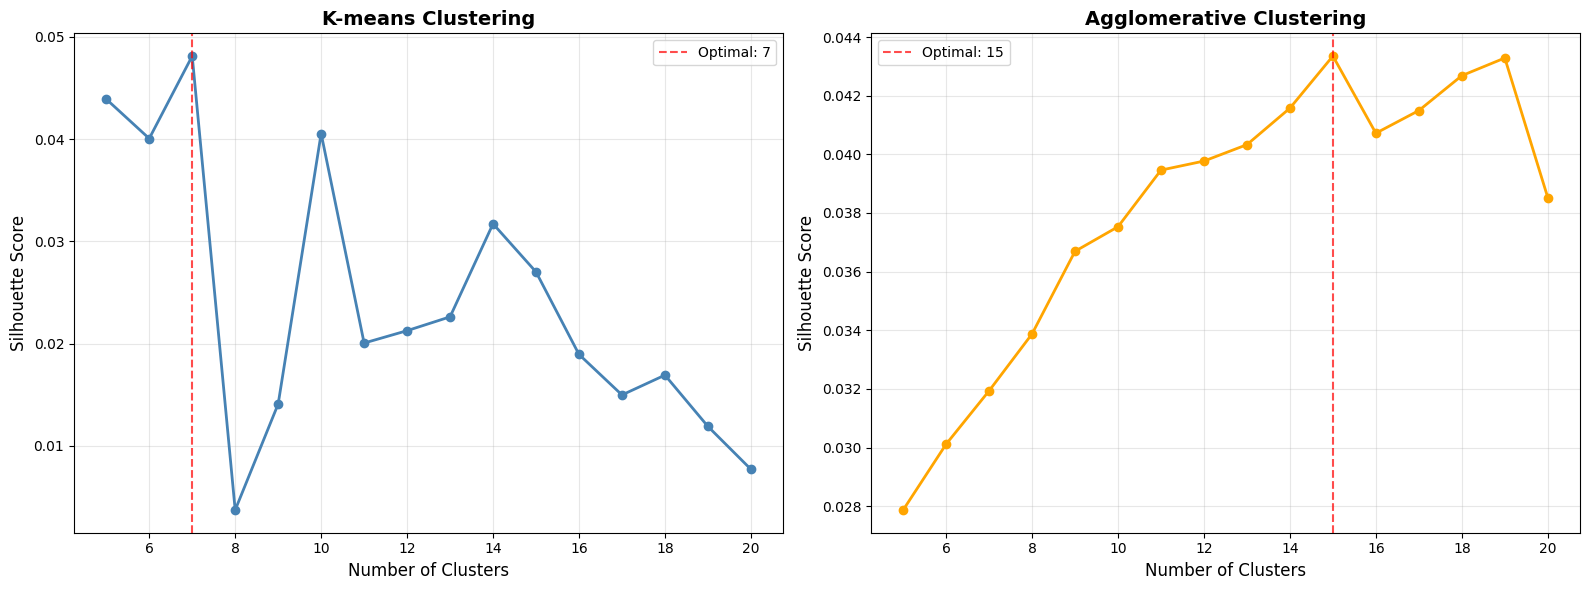


K-MEANS CLUSTERING ANALYSIS (n_clusters=7)

Cluster 0 (size: 67):
  1. 机器     - machine              (freq: 1709)
  2. 女人     - woman                (freq: 14388)
  3. 男人     - man                  (freq: 11608)
  4. 电脑     - computer             (freq: 3210)
  5. 好人     - good guy             (freq: 1798)
  6. 食物     - food                 (freq: 2561)
  7. 家伙     - guy                  (freq: 13846)
  8. 爱情     - love                 (freq: 1906)
  9. 礼物     - gift                 (freq: 3988)
  10. 白痴     - idiot                (freq: 3446)
  11. 杀手     - killer               (freq: 2559)
  12. 无辜     - innocent             (freq: 1449)
  13. 好事     - good thing           (freq: 1947)
  14. 恶魔     - demon                (freq: 1834)
  15. 生气     - angry                (freq: 1800)
  16. 人们     - people               (freq: 7990)
  17. 派对     - party                (freq: 4231)
  18. 汽车     - car                  (freq: 2373)
  19. 英雄     - hero                 (freq: 2779)
  20. 黑人

In [6]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Use top 500 embeddings
top_n = 500
embeddings_top500 = embeddings[:top_n]
nouns_top500 = df_noun_top2500.head(top_n)

# Grid search parameters
cluster_range = range(5, 21)  # 5 to 20 clusters

# Run grid search using helper function
search_results = run_clustering_grid_search(embeddings_top500, cluster_range, method='both')
agg_scores = search_results['agg_scores']
kmeans_scores = search_results['kmeans_scores']

# Find optimal number of clusters for each method
optimal_agg_idx = np.argmax(agg_scores)
optimal_agg_clusters_raw = list(cluster_range)[optimal_agg_idx]

optimal_kmeans_idx = np.argmax(kmeans_scores)
optimal_kmeans_clusters = list(cluster_range)[optimal_kmeans_idx]

print("\n" + "=" * 60)
print(f"Optimal K-means:        {optimal_kmeans_clusters} clusters (silhouette={kmeans_scores[optimal_kmeans_idx]:.4f})")
print(f"Optimal Agglomerative:  {optimal_agg_clusters_raw} clusters (silhouette={agg_scores[optimal_agg_idx]:.4f})")
print("=" * 60)

# Plot silhouette scores using helper function
plot_silhouette_comparison(
    cluster_range,
    {'kmeans': kmeans_scores, 'agg': agg_scores},
    {'kmeans': optimal_kmeans_clusters, 'agg': optimal_agg_clusters_raw},
    {'kmeans': 'K-means Clustering', 'agg': 'Agglomerative Clustering'}
)

# Analyze K-means clusters
print("\n" + "=" * 60)
print(f"K-MEANS CLUSTERING ANALYSIS (n_clusters={optimal_kmeans_clusters})")
print("=" * 60)

kmeans_optimal = KMeans(n_clusters=optimal_kmeans_clusters, random_state=42, n_init=10)
kmeans_optimal_labels = kmeans_optimal.fit_predict(embeddings_top500)

kmeans_results = find_representative_nouns(
    embeddings_top500, 
    kmeans_optimal_labels, 
    nouns_top500, 
    optimal_kmeans_clusters
)

for cluster_info in kmeans_results:
    print(f"\nCluster {cluster_info['cluster_id']} (size: {cluster_info['size']}):")
    for i, rep in enumerate(cluster_info['representatives'], 1):
        print(f"  {i}. {rep['Noun']:6s} - {rep['English']:20s} (freq: {rep['Frequency']:.0f})")

# Analyze Agglomerative clusters
print("\n" + "=" * 60)
print(f"\nAGGLOMERATIVE CLUSTERING ANALYSIS (n_clusters={optimal_agg_clusters_raw})")
print("=" * 60)

agg_optimal = AgglomerativeClustering(n_clusters=optimal_agg_clusters_raw)
agg_optimal_labels = agg_optimal.fit_predict(embeddings_top500)

agg_results = find_representative_nouns(
    embeddings_top500, 
    agg_optimal_labels, 
    nouns_top500, 
    optimal_agg_clusters_raw
)

for cluster_info in agg_results:
    print(f"\nCluster {cluster_info['cluster_id']} (size: {cluster_info['size']}):")
    for i, rep in enumerate(cluster_info['representatives'], 1):
        print(f"  {i}. {rep['Noun']:6s} - {rep['English']:20s} (freq: {rep['Frequency']:.0f})")

print("\n" + "=" * 60)

---

Agglomerative clustering produced 15 clusters, with 9 showing strong semantic coherence - 5 of which were near-perfect.

K-means, despite having a higher silhouette score, produced 7 clusters that grouped semantically distinct words too broadly.

To improve scalability and clustering quality, PCA dimensionality reduction will be tested across different component counts.

## PCA Optimisation

### Silhouette Score Analysis

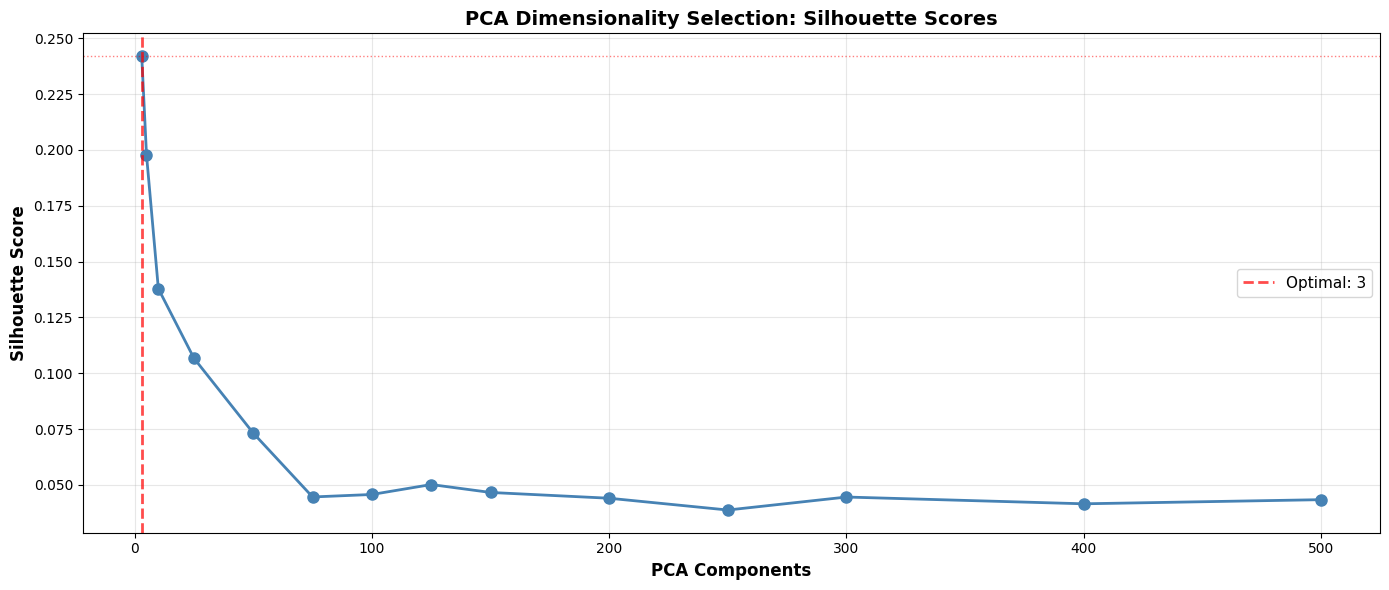


AGGLOMERATIVE CLUSTERING WITH 3 PCA COMPONENTS

Cluster 0 (size: 79):
  1. 炸弹     - bomb                 (freq: 2268)
  2. 报纸     - newspaper            (freq: 1710)
  3. 同志     - comrade              (freq: 1873)
  4. 灵魂     - soul                 (freq: 2425)
  5. 好运     - good luck            (freq: 3289)
  6. 心脏     - heart                (freq: 1830)
  7. 主意     - idea                 (freq: 6144)
  8. 评委     - judges               (freq: 2253)
  9. 尸体     - corpse               (freq: 4994)
  10. 家族     - family               (freq: 1822)
  11. 客户     - client               (freq: 2168)
  12. 星球     - planet               (freq: 1454)
  13. 子弹     - bullet               (freq: 2488)
  14. 小组     - group                (freq: 1655)
  15. 大脑     - brain                (freq: 1461)
  16. 汽车     - car                  (freq: 2373)
  17. 内心     - heart                (freq: 1444)
  18. 成员     - member               (freq: 2088)
  19. 旅馆     - hostel               (freq: 1722)
  20. 军

In [7]:
from sklearn.decomposition import PCA

# PCA grid search parameters
pca_components = [3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500]

# Store results
pca_scores = []
pca_embeddings_dict = {}

for n_components in pca_components:
    # Apply PCA
    pca = PCA(n_components=n_components, random_state=42)
    embeddings_pca = pca.fit_transform(embeddings_top500)
    
    # Store PCA-transformed embeddings
    pca_embeddings_dict[n_components] = embeddings_pca
    
    # Apply Agglomerative Clustering
    agg = AgglomerativeClustering(n_clusters=optimal_agg_clusters_raw)
    labels = agg.fit_predict(embeddings_pca)
    
    # Calculate silhouette score
    silhouette = silhouette_score(embeddings_pca, labels)
    pca_scores.append(silhouette)

# Find optimal PCA components
optimal_idx = np.argmax(pca_scores)
optimal_pca = pca_components[optimal_idx]
optimal_score = pca_scores[optimal_idx]

# Plot silhouette scores vs PCA components
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(pca_components, pca_scores, marker='o', linewidth=2, markersize=8, 
        color='steelblue')
ax.axvline(x=optimal_pca, color='r', linestyle='--', alpha=0.7, linewidth=2,
           label=f'Optimal: {optimal_pca}')
ax.axhline(y=optimal_score, color='r', linestyle=':', alpha=0.5, linewidth=1)

ax.set_xlabel('PCA Components', fontsize=12, fontweight='bold')
ax.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax.set_title('PCA Dimensionality Selection: Silhouette Scores', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# Analyze clusters with optimal PCA
print("\n" + "=" * 60)
print(f"AGGLOMERATIVE CLUSTERING WITH {optimal_pca} PCA COMPONENTS")
print("=" * 60)

# Get optimal PCA embeddings
optimal_embeddings = pca_embeddings_dict[optimal_pca]

# Fit optimal clustering
agg_optimal = AgglomerativeClustering(n_clusters=optimal_agg_clusters_raw)
optimal_labels = agg_optimal.fit_predict(optimal_embeddings)

# Find representative nouns using the existing function
optimal_results = find_representative_nouns(
    optimal_embeddings, 
    optimal_labels, 
    nouns_top500, 
    optimal_agg_clusters_raw,
    n_representatives=25
)

# Sort clusters by size (descending) for better readability
optimal_results_sorted = sorted(optimal_results, key=lambda x: x['size'], reverse=True)

for cluster_info in optimal_results_sorted:
    print(f"\nCluster {cluster_info['cluster_id']} (size: {cluster_info['size']}):")
    for i, rep in enumerate(cluster_info['representatives'], 1):
        print(f"  {i}. {rep['Noun']:6s} - {rep['English']:20s} (freq: {rep['Frequency']:.0f})")

print("\n" + "=" * 60)
print(f"\nSummary:")
print(f"  • Best PCA components: {optimal_pca}")
print(f"  • Number of clusters: {optimal_agg_clusters_raw}")
print(f"  • Silhouette score: {optimal_score:.4f}")
# Get explained variance for optimal PCA
optimal_pca_model = PCA(n_components=optimal_pca, random_state=42)
optimal_pca_model.fit(embeddings_top500)
print(f"  • Explained variance: {sum(optimal_pca_model.explained_variance_ratio_):.2%}")
print("=" * 60)

---

The PCA grid search selected 3 components as optimal based on silhouette score, but most of the clusters formed were incohesive.

This metric has a critical limitation:

**Silhouette scores measure geometric separation, not semantic coherence.**

At very low dimensions, geometric compression appears to artificially inflate silhouette scores.

**To properly evaluate PCA dimensionality, cluster quality needs to be validated in the original embedding space.**

The enhanced analysis below addresses this by computing:
- **Reconstruction fidelity:** How much information does PCA lose?
- **Baseline similarity:** Does PCA preserve the natural clustering structure?
- **Intra-cluster coherence:** Are cluster members semantically similar in original space?
- **Inter-centroid separation:** Are clusters distinct in original space?

This allows us to distinguish between geometric artifacts and genuine semantic clustering improvements.

### Semantic Coherence Validation

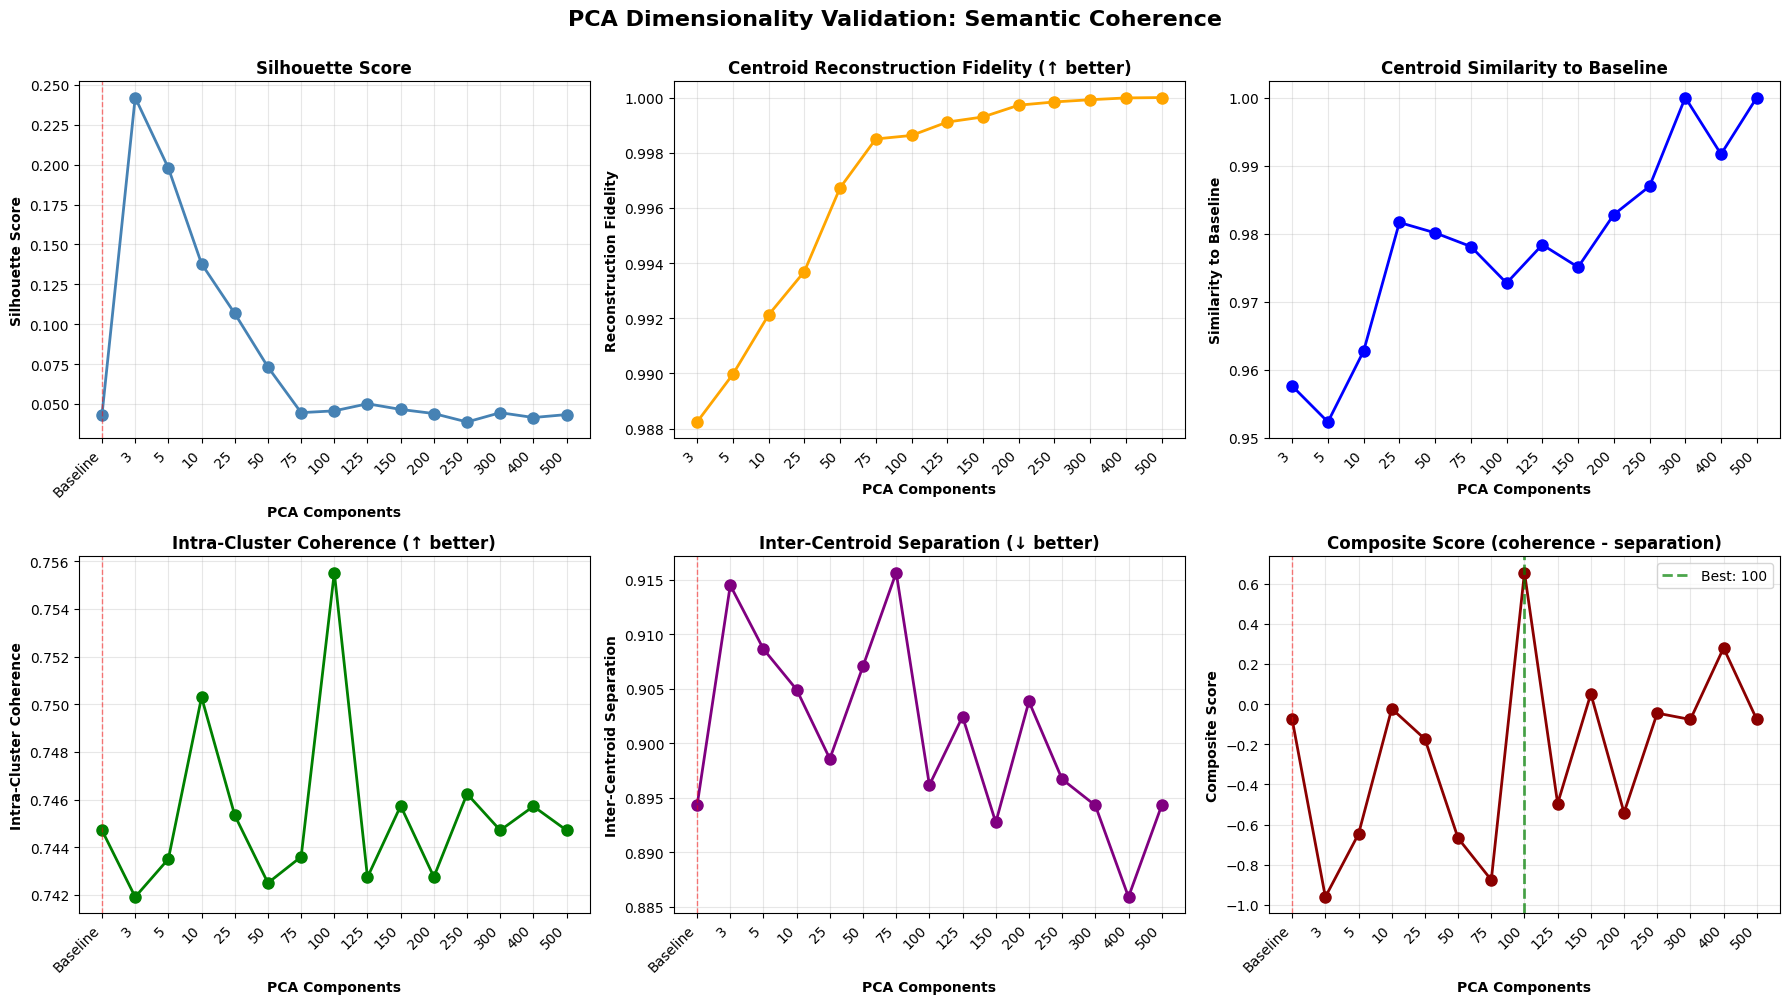

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment

# Compute baseline clustering (no PCA) for comparison
agg_baseline = AgglomerativeClustering(n_clusters=optimal_agg_clusters_raw)
baseline_labels = agg_baseline.fit_predict(embeddings_top500)

# Compute baseline centroids in original space
baseline_centroids = []
for i in range(optimal_agg_clusters_raw):
    cluster_mask = baseline_labels == i
    centroid = embeddings_top500[cluster_mask].mean(axis=0)
    baseline_centroids.append(centroid)
baseline_centroids = np.array(baseline_centroids)

# Enhanced metrics function
def compute_enhanced_metrics(embeddings_pca, embeddings_original, labels, n_clusters, 
                              baseline_centroids, pca_transformer=None):
    metrics_list = []
    
    # Compute post-PCA centroids in ORIGINAL space
    pca_centroids_original = []
    for i in range(n_clusters):
        cluster_mask = labels == i
        centroid_original = embeddings_original[cluster_mask].mean(axis=0)
        pca_centroids_original.append(centroid_original)
    pca_centroids_original = np.array(pca_centroids_original)
    
    # Match post-PCA clusters to baseline clusters using Hungarian algorithm
    centroid_similarity_matrix = cosine_similarity(pca_centroids_original, baseline_centroids)
    row_ind, col_ind = linear_sum_assignment(-centroid_similarity_matrix)  # negative because it minimizes
    best_matches = {row_ind[i]: col_ind[i] for i in range(len(row_ind))}
    
    for cluster_id in range(n_clusters):
        cluster_mask = labels == cluster_id
        cluster_members = embeddings_original[cluster_mask]
        n_members = cluster_members.shape[0]
        
        if n_members < 2:
            continue
        
        centroid_original = pca_centroids_original[cluster_id]
        
        # Intra-cluster coherence
        pairwise_sim = cosine_similarity(cluster_members)
        mask = ~np.eye(pairwise_sim.shape[0], dtype=bool)
        intra_coherence = pairwise_sim[mask].mean() if mask.sum() > 0 else 1.0
        
        # Inter-centroid separation
        other_centroids = np.delete(pca_centroids_original, cluster_id, axis=0)
        inter_separation = cosine_similarity(
            centroid_original.reshape(1, -1), 
            other_centroids
        ).mean()
        
        # Baseline similarity
        best_baseline_idx = best_matches[cluster_id]
        baseline_similarity = cosine_similarity(
            centroid_original.reshape(1, -1),
            baseline_centroids[best_baseline_idx].reshape(1, -1)
        )[0, 0]
        
        # Reconstruction fidelity
        if pca_transformer is not None:
            centroid_pca = embeddings_pca[cluster_mask].mean(axis=0)
            centroid_reconstructed = pca_transformer.inverse_transform(
                centroid_pca.reshape(1, -1)
            )[0]
            reconstruction_fidelity = cosine_similarity(
                centroid_original.reshape(1, -1),
                centroid_reconstructed.reshape(1, -1)
            )[0, 0]
        else:
            reconstruction_fidelity = 1.0
        
        metrics_list.append({
            'cluster_id': cluster_id,
            'n_members': n_members,
            'intra_coherence': intra_coherence,
            'inter_separation': inter_separation,
            'baseline_similarity': baseline_similarity,
            'reconstruction_fidelity': reconstruction_fidelity,
            'matched_baseline_cluster': best_baseline_idx
        })
    
    return pd.DataFrame(metrics_list)

# Compute metrics for all PCA levels
pca_summary = []

# Baseline
baseline_metrics_df = compute_enhanced_metrics(
    embeddings_top500, embeddings_top500, baseline_labels, 
    optimal_agg_clusters_raw, baseline_centroids, pca_transformer=None
)
pca_summary.append({
    'pca_components': 'Baseline',
    'mean_intra_coherence': baseline_metrics_df['intra_coherence'].mean(),
    'mean_inter_separation': baseline_metrics_df['inter_separation'].mean(),
    'mean_baseline_similarity': baseline_metrics_df['baseline_similarity'].mean(),
    'mean_reconstruction_fidelity': baseline_metrics_df['reconstruction_fidelity'].mean(),
    'silhouette_score': silhouette_score(embeddings_top500, baseline_labels)
})

# Each PCA level
for i, n_components in enumerate(pca_components):
    pca = PCA(n_components=n_components, random_state=42)
    embeddings_pca = pca.fit_transform(embeddings_top500)
    
    agg = AgglomerativeClustering(n_clusters=optimal_agg_clusters_raw)
    labels = agg.fit_predict(embeddings_pca)
    
    metrics_df = compute_enhanced_metrics(
        embeddings_pca, embeddings_top500, labels, optimal_agg_clusters_raw,
        baseline_centroids, pca_transformer=pca
    )
    
    pca_summary.append({
        'pca_components': n_components,
        'mean_intra_coherence': metrics_df['intra_coherence'].mean(),
        'mean_inter_separation': metrics_df['inter_separation'].mean(),
        'mean_baseline_similarity': metrics_df['baseline_similarity'].mean(),
        'mean_reconstruction_fidelity': metrics_df['reconstruction_fidelity'].mean(),
        'silhouette_score': pca_scores[i],
        'explained_variance': pca.explained_variance_ratio_.sum()
    })

summary_metrics = pd.DataFrame(pca_summary)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PCA Dimensionality Validation: Semantic Coherence', 
             fontsize=16, fontweight='bold', y=1.00)

plot_data = summary_metrics.copy()
plot_data['pca_numeric'] = plot_data['pca_components'].apply(
    lambda x: -10 if x == 'Baseline' else x
)
plot_data = plot_data.sort_values('pca_numeric')
x_vals = range(len(plot_data))

# Plot 1: Silhouette Score
ax1 = axes[0, 0]
ax1.plot(x_vals, plot_data['silhouette_score'], marker='o', linewidth=2, 
         markersize=8, color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax1.set_xlabel('PCA Components', fontweight='bold')
ax1.set_ylabel('Silhouette Score', fontweight='bold')
ax1.set_title('Silhouette Score', fontweight='bold')
ax1.set_xticks(x_vals)
ax1.set_xticklabels(plot_data['pca_components'], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

# Plot 2: Reconstruction Fidelity
ax2 = axes[0, 1]
ax2.plot(x_vals[1:], plot_data['mean_reconstruction_fidelity'].iloc[1:], marker='o', 
         linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('PCA Components', fontweight='bold')
ax2.set_ylabel('Reconstruction Fidelity', fontweight='bold')
ax2.set_title('Centroid Reconstruction Fidelity (↑ better)', fontweight='bold')
ax2.set_xticks(x_vals[1:])
ax2.set_xticklabels(plot_data['pca_components'].iloc[1:], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Plot 3: Baseline Similarity
ax3 = axes[0, 2]
ax3.plot(x_vals[1:], plot_data['mean_baseline_similarity'].iloc[1:], marker='o', 
         linewidth=2, markersize=8, color='blue')
ax3.set_xlabel('PCA Components', fontweight='bold')
ax3.set_ylabel('Similarity to Baseline', fontweight='bold')
ax3.set_title('Centroid Similarity to Baseline', fontweight='bold')
ax3.set_xticks(x_vals[1:])
ax3.set_xticklabels(plot_data['pca_components'].iloc[1:], rotation=45, ha='right')
ax3.grid(True, alpha=0.3)

# Plot 4: Intra-cluster Coherence
ax4 = axes[1, 0]
ax4.plot(x_vals, plot_data['mean_intra_coherence'], marker='o', linewidth=2, 
         markersize=8, color='green')
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax4.set_xlabel('PCA Components', fontweight='bold')
ax4.set_ylabel('Intra-Cluster Coherence', fontweight='bold')
ax4.set_title('Intra-Cluster Coherence (↑ better)', fontweight='bold')
ax4.set_xticks(x_vals)
ax4.set_xticklabels(plot_data['pca_components'], rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

# Plot 5: Inter-Centroid Separation
ax5 = axes[1, 1]
ax5.plot(x_vals, plot_data['mean_inter_separation'], marker='o', linewidth=2, 
         markersize=8, color='purple')
ax5.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax5.set_xlabel('PCA Components', fontweight='bold')
ax5.set_ylabel('Inter-Centroid Separation', fontweight='bold')
ax5.set_title('Inter-Centroid Separation (↓ better)', fontweight='bold')
ax5.set_xticks(x_vals)
ax5.set_xticklabels(plot_data['pca_components'], rotation=45, ha='right')
ax5.grid(True, alpha=0.3)

# Plot 6: Composite Score
ax6 = axes[1, 2]
plot_data['composite'] = (
    (plot_data['mean_intra_coherence'] - plot_data['mean_intra_coherence'].min()) / 
    (plot_data['mean_intra_coherence'].max() - plot_data['mean_intra_coherence'].min()) -
    (plot_data['mean_inter_separation'] - plot_data['mean_inter_separation'].min()) / 
    (plot_data['mean_inter_separation'].max() - plot_data['mean_inter_separation'].min())
)
ax6.plot(x_vals, plot_data['composite'], marker='o', linewidth=2, 
         markersize=8, color='darkred')
ax6.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
best_idx = plot_data['composite'].idxmax()
best_x = plot_data.index.get_loc(best_idx)
ax6.axvline(x=best_x, color='green', linestyle='--', alpha=0.7, linewidth=2,
            label=f'Best: {plot_data.iloc[best_idx]["pca_components"]}')
ax6.set_xlabel('PCA Components', fontweight='bold')
ax6.set_ylabel('Composite Score', fontweight='bold')
ax6.set_title('Composite Score (coherence - separation)', fontweight='bold')
ax6.set_xticks(x_vals)
ax6.set_xticklabels(plot_data['pca_components'], rotation=45, ha='right')
ax6.grid(True, alpha=0.3)
ax6.legend()

plt.tight_layout()
plt.show()

In [9]:
# Function to find best matching clusters between two clusterings
def match_clusters(baseline_labels, pca_labels, n_clusters):
    """Find best matching clusters between baseline and PCA using overlap."""
    from scipy.optimize import linear_sum_assignment
    
    # Create overlap matrix
    overlap_matrix = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            overlap = np.sum((baseline_labels == i) & (pca_labels == j))
            overlap_matrix[i, j] = overlap
    
    # Use Hungarian algorithm to find best matching
    row_ind, col_ind = linear_sum_assignment(-overlap_matrix)
    
    # Create mapping from PCA cluster to baseline cluster
    pca_to_baseline = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}
    
    return pca_to_baseline

def display_clusters_side_by_side(group1_data, group2_data, group1_labels, group2_labels, n_clusters, 
                                   group1_title, group2_title, n_shared_words=None):
    """
    Display two clusterings side-by-side with matched clusters.
    
    Parameters:
    - group1_data, group2_data: dictionaries of representative words for each cluster
    - group1_labels, group2_labels: full cluster label arrays for each group
    - n_clusters: number of clusters
    - group1_title, group2_title: display titles
    - n_shared_words: if provided, match clusters based on first N shared words; 
                      otherwise match based on all words in group1
    """
    from scipy.optimize import linear_sum_assignment
    
    # Determine which words to use for matching
    if n_shared_words is None:
        n_shared_words = len(group1_labels)
    
    # Match clusters based on shared words only
    overlap_matrix = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            # Count overlap in the shared words
            overlap = np.sum((group1_labels[:n_shared_words] == i) & 
                           (group2_labels[:n_shared_words] == j))
            overlap_matrix[i, j] = overlap
    
    # Use Hungarian algorithm to find best matching
    row_ind, col_ind = linear_sum_assignment(-overlap_matrix)
    group1_to_group2 = {row_ind[i]: col_ind[i] for i in range(len(row_ind))}
    
    # Get cluster sizes from FULL label arrays
    group1_sizes = [(i, sum(group1_labels == i)) for i in range(n_clusters)]
    group1_sizes.sort(key=lambda x: x[0])  # Sort by cluster number
    
    print("=" * 160)
    print(f"{group1_title:^80s}{group2_title:^80s}")
    print("=" * 160)
    print()
    
    for group1_cluster_id, group1_size in group1_sizes:
        # Find matching cluster in group2
        group2_cluster_id = group1_to_group2[group1_cluster_id]
        group2_size = sum(group2_labels == group2_cluster_id)
        
        # Group 1 cluster
        words = group1_data[group1_cluster_id]
        group1_lines = [f"Cluster {group1_cluster_id:2d} (size: {group1_size:3d})"]
        group1_lines.append("─" * 78)
        for i, word in enumerate(words, 1):
            group1_lines.append(f"  {i:2d}. {word['Noun']:6s} - {word['English']:20s} (freq: {word['Frequency']:>6.0f})")
        
        # Group 2 cluster (matched)
        words = group2_data[group2_cluster_id]
        group2_lines = [f"Cluster {group2_cluster_id:2d} (size: {group2_size:3d})"]
        group2_lines.append("─" * 78)
        for i, word in enumerate(words, 1):
            group2_lines.append(f"  {i:2d}. {word['Noun']:6s} - {word['English']:20s} (freq: {word['Frequency']:>6.0f})")
        
        # Print side by side
        max_lines = max(len(group1_lines), len(group2_lines))
        for line_idx in range(max_lines):
            group1_line = group1_lines[line_idx] if line_idx < len(group1_lines) else ""
            group2_line = group2_lines[line_idx] if line_idx < len(group2_lines) else ""
            print(f"{group1_line:78s}  {group2_line:78s}")
        
        print()

# Create 100-dim PCA embeddings and labels for comparison
embeddings_pca100 = pca_embeddings_dict[100]

# Cluster with 100-dim PCA using the same number of clusters as baseline
agg_pca100 = AgglomerativeClustering(n_clusters=optimal_agg_clusters_raw)
labels_pca100 = agg_pca100.fit_predict(embeddings_pca100)

# Get top 25 words for both configurations
pca_top25 = find_representative_nouns(embeddings_pca100, labels_pca100, nouns_top500, optimal_agg_clusters_raw, n_representatives=25, return_dict=True)
baseline_top25 = find_representative_nouns(embeddings_top500, baseline_labels, nouns_top500, optimal_agg_clusters_raw, n_representatives=25, return_dict=True)

# Display clusters side-by-side
display_clusters_side_by_side(baseline_top25, pca_top25, baseline_labels, labels_pca100, optimal_agg_clusters_raw,
                               group1_title='BASELINE (ORIGINAL EMBEDDINGS)',
                               group2_title='100 PCA DIMENSIONS')

                         BASELINE (ORIGINAL EMBEDDINGS)                                                        100 PCA DIMENSIONS                               

Cluster  0 (size:  87)                                                          Cluster  4 (size:  60)                                                        
──────────────────────────────────────────────────────────────────────────────  ──────────────────────────────────────────────────────────────────────────────
   1. 情况     - condition            (freq:  10673)                                 1. 结果     - result               (freq:   6902)                            
   2. 名单     - list                 (freq:   2212)                                 2. 名单     - list                 (freq:   2212)                            
   3. 结果     - result               (freq:   6902)                                 3. 关键     - key                  (freq:   1791)                            
   4. 信息     - information          (freq: 

---

Agglomerative clustering after PCA reduction to 100 dimensions produced 10 coherent clusters from the 15, with 8 showing near-perfect semantic coherence - a much cleaner structure compared to the raw embeddings!

With PCA reduction established, optimal cluster count will be re-assessed and different vocabulary sizes will be tested.

## Clustering Analysis

### Top 500

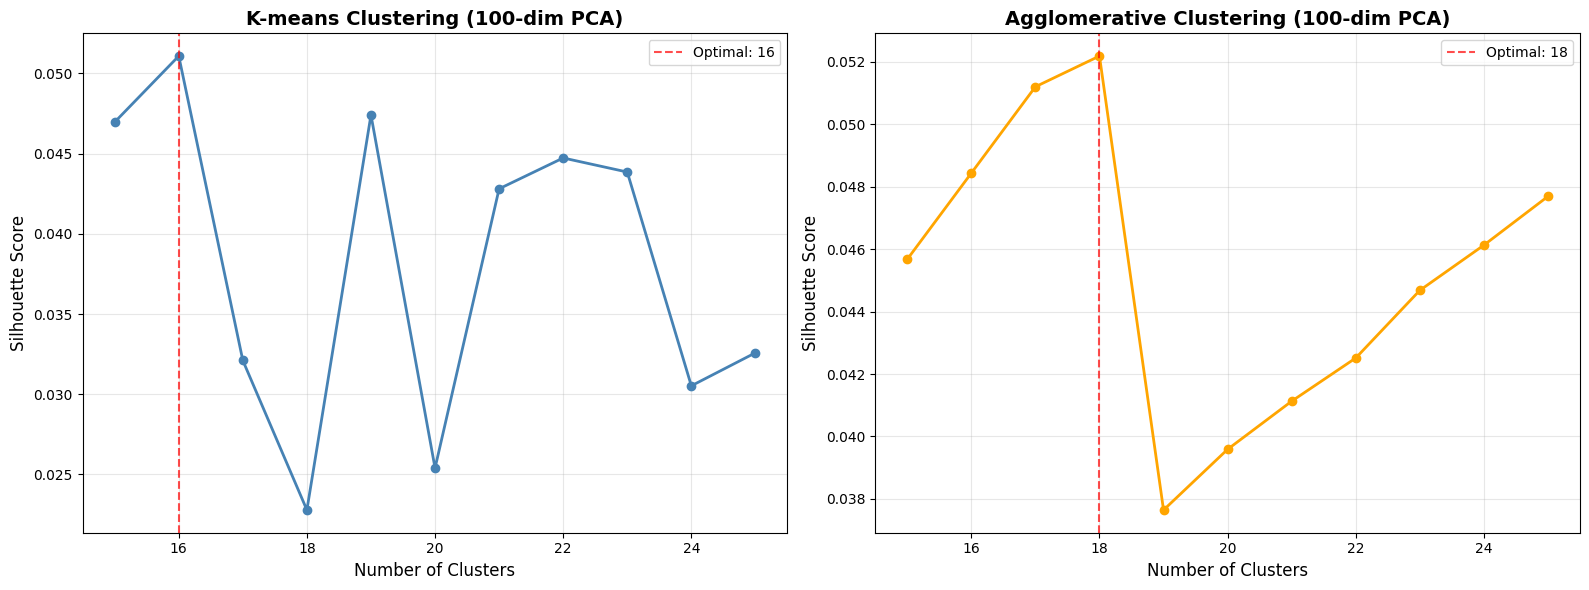

                        K-MEANS CLUSTERING (100-DIM PCA)                        

────────────────────────────────────────────────────────────────────────────────
Cluster  0 (size:  17)
────────────────────────────────────────────────────────────────────────────────
   1. 私人     - private              (freq:   2515)
   2. 军队     - army                 (freq:   1870)
   3. 家人     - family               (freq:   2875)
   4. 家庭     - family               (freq:   5017)
   5. 国家     - nation               (freq:   5576)
   6. 部门     - department           (freq:   1526)
   7. 部分     - part                 (freq:   2782)
   8. 家族     - family               (freq:   1822)
   9. 个人     - personal             (freq:   3597)
  10. 公司     - company              (freq:  10046)
  11. 事业     - cause                (freq:   1634)
  12. 部落     - tribe                (freq:   2197)
  13. 公园     - garden               (freq:   2206)
  14. 公寓     - apartment            (freq:   2706)
  15. 俱乐部    - club

In [ ]:
# Use 100-dimension PCA embeddings (fixed)
embeddings_pca100 = pca_embeddings_dict[100]
nouns_top500 = df_noun_top2500.head(top_n)

# Grid search parameters
cluster_range = range(15, 26)  # 15 to 25 clusters

# Run grid search using helper function
search_results = run_clustering_grid_search(embeddings_pca100, cluster_range, method='both')
agg_scores = search_results['agg_scores']
kmeans_scores = search_results['kmeans_scores']

# Find optimal number of clusters for each method
optimal_agg_idx_500 = np.argmax(agg_scores)
optimal_agg_clusters_500 = list(cluster_range)[optimal_agg_idx_500]

optimal_kmeans_idx_500 = np.argmax(kmeans_scores)
optimal_kmeans_clusters_500 = list(cluster_range)[optimal_kmeans_idx_500]

# Plot silhouette scores using helper function
plot_silhouette_comparison(
    cluster_range,
    {'kmeans': kmeans_scores, 'agg': agg_scores},
    {'kmeans': optimal_kmeans_clusters_500, 'agg': optimal_agg_clusters_500},
    {'kmeans': 'K-means Clustering (100-dim PCA)', 'agg': 'Agglomerative Clustering (100-dim PCA)'}
)

# Fit optimal models
kmeans_optimal_500 = KMeans(n_clusters=optimal_kmeans_clusters_500, random_state=42, n_init=10)
kmeans_optimal_labels_500 = kmeans_optimal_500.fit_predict(embeddings_pca100)

agg_optimal_500 = AgglomerativeClustering(n_clusters=optimal_agg_clusters_500)
agg_optimal_labels_500 = agg_optimal_500.fit_predict(embeddings_pca100)

# Get top 25 words for both methods
kmeans_top25_500 = find_representative_nouns(embeddings_pca100, kmeans_optimal_labels_500, nouns_top500, optimal_kmeans_clusters_500, n_representatives=25, return_dict=True)
agg_top25_500 = find_representative_nouns(embeddings_pca100, agg_optimal_labels_500, nouns_top500, optimal_agg_clusters_500, n_representatives=25, return_dict=True)

# Function to display clusters
def display_clusters(cluster_data, labels, title, n_clusters):
    """Display clusters in a formatted way."""
    print("=" * 80)
    print(f"{title:^80s}")
    print("=" * 80)
    print()
    
    # Calculate cluster sizes
    cluster_sizes = {i: sum(labels == i) for i in range(n_clusters)}
    
    # Sort clusters by ID for consistent display
    for cluster_id in sorted(cluster_data.keys()):
        words = cluster_data[cluster_id]
        size = cluster_sizes.get(cluster_id, 0)
        
        print("─" * 80)
        print(f"Cluster {cluster_id:2d} (size: {size:3d})")
        print("─" * 80)
        
        for i, word in enumerate(words, 1):
            print(f"  {i:2d}. {word['Noun']:6s} - {word['English']:20s} (freq: {word['Frequency']:>6.0f})")
        print()

# Display results
display_clusters(kmeans_top25_500, kmeans_optimal_labels_500, "K-MEANS CLUSTERING (100-DIM PCA)", optimal_kmeans_clusters_500)
print("\n\n")
display_clusters(agg_top25_500, agg_optimal_labels_500, "AGGLOMERATIVE CLUSTERING (100-DIM PCA)", optimal_agg_clusters_500)

---

After reducing to 100 PCA dimensions, K-means continued to struggle with forming coherent clusters, and will therefore be omitted from subsequent analyses.

Agglomerative clustering performed better with 18 clusters than with 15.
Using 18 clusters resulted in 12 semantically coherent groups (two more than with 15 clusters), and nine of these showed near-perfect cohesion.

To investigate whether additional vocabulary improves cluster resolution, the analysis will be extended to the top 1000 words.

### Top 1000

In [11]:
# Use top 1000 embeddings
top_n_1000 = 1000
embeddings_top1000 = embeddings[:top_n_1000]
nouns_top1000 = df_noun_top2500.head(top_n_1000)

# Apply 100-dimension PCA to top 1000 embeddings (fit once, reuse below)
pca_100_top1000 = PCA(n_components=100, random_state=42)
embeddings_pca100_top1000 = pca_100_top1000.fit_transform(embeddings_top1000)

# Test with 18 clusters (agglomerative only)
n_clusters = 18

# Fit agglomerative clustering on top 1000 words
agg_1000 = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels_1000 = agg_1000.fit_predict(embeddings_pca100_top1000)
agg_silhouette_1000 = silhouette_score(embeddings_pca100_top1000, agg_labels_1000)

# Fit agglomerative clustering on top 500 words (for comparison)
agg_500 = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels_500 = agg_500.fit_predict(embeddings_pca100)
agg_silhouette_500 = silhouette_score(embeddings_pca100, agg_labels_500)

# Get top 25 words for both datasets
agg_top25_500 = find_representative_nouns(embeddings_pca100, agg_labels_500, nouns_top500, n_clusters, n_representatives=25, return_dict=True)
agg_top25_1000 = find_representative_nouns(embeddings_pca100_top1000, agg_labels_1000, nouns_top1000, n_clusters, n_representatives=25, return_dict=True)

# Extract labels for first 500 words from top1000 dataset for matching
# (top1000 contains top500, so first 500 indices correspond to same words)
agg_labels_1000_first500 = agg_labels_1000[:500]

# Display clusters side-by-side (sorted by top500 cluster numbers)
display_clusters_side_by_side(agg_top25_500, agg_top25_1000, agg_labels_500, agg_labels_1000, n_clusters,
                               group1_title='TOP 500 WORDS',
                               group2_title='TOP 1000 WORDS',
                               n_shared_words=500)  # Match based on first 500 shared words

                                 TOP 500 WORDS                                                                   TOP 1000 WORDS                                 

Cluster  0 (size:  98)                                                          Cluster 15 (size: 140)                                                        
──────────────────────────────────────────────────────────────────────────────  ──────────────────────────────────────────────────────────────────────────────
   1. 命      - life                 (freq:   3886)                                 1. 光      - light                (freq:   2694)                            
   2. 光      - light                (freq:   2694)                                 2. 菜      - vegetable            (freq:   1963)                            
   3. 菜      - vegetable            (freq:   1963)                                 3. 命      - life                 (freq:   3886)                            
   4. 电      - electricity          (freq: 

---

Expanding to 1000 words caused a slight decline in clustering quality. Though many stable clusters persisted, the number of coherent clusters dropped to 11, and heterogeneous clusters absorbed a greater share of the vocabulary.

A larger range of cluster counts will be tested to determine whether finer granularity helps to maintain semantic coherence.

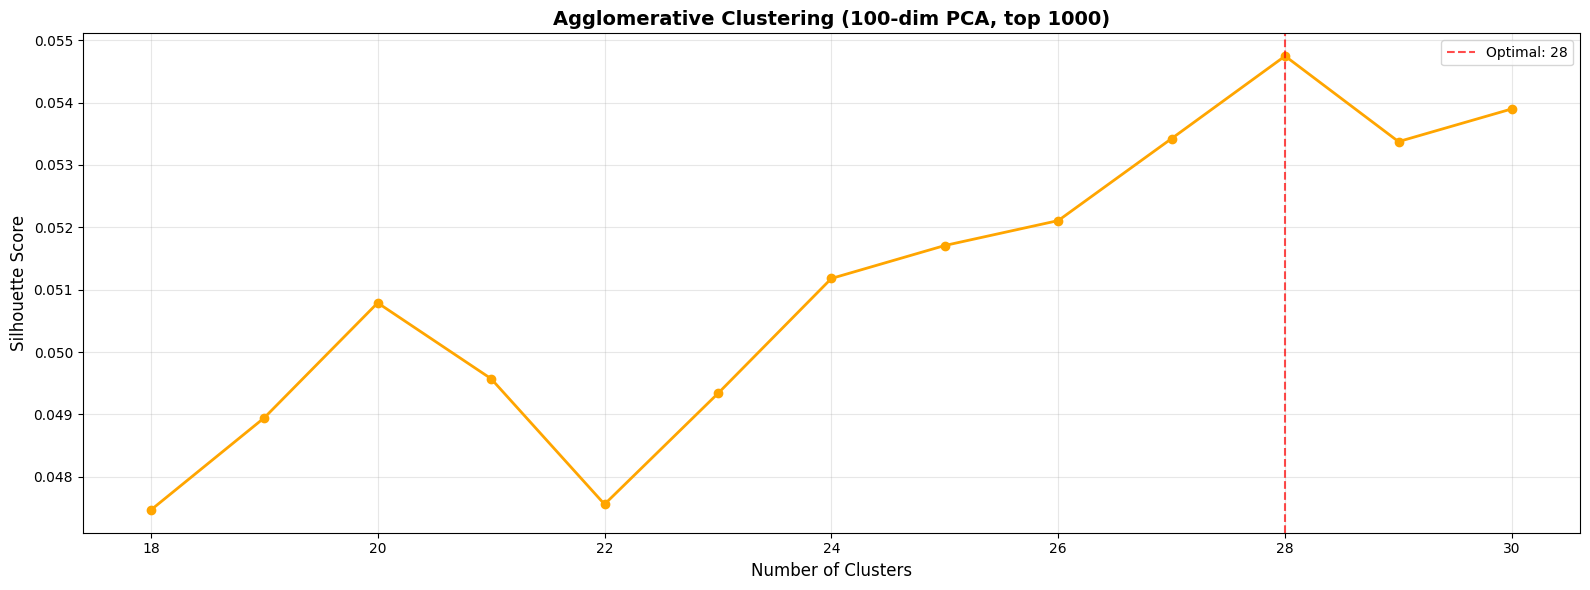

                AGGLOMERATIVE CLUSTERING (100-DIM PCA, TOP 1000)                

────────────────────────────────────────────────────────────────────────────────
Cluster  0 (size: 111)
────────────────────────────────────────────────────────────────────────────────
   1. 讲话     - speech               (freq:    851)
   2. 技巧     - skill                (freq:    806)
   3. 形象     - image                (freq:    790)
   4. 市场     - market               (freq:   1078)
   5. 阳光     - sunlight             (freq:   1107)
   6. 问题     - question             (freq:  33364)
   7. 交易     - trade                (freq:   2070)
   8. 损失     - loss                 (freq:    887)
   9. 照片     - photo                (freq:   8687)
  10. 细节     - detail               (freq:   1400)
  11. 经历     - experience           (freq:   1714)
  12. 话      - talk                 (freq:  39887)
  13. 时代     - era                  (freq:   1544)
  14. 同时     - at the same time     (freq:    887)
  15. 空间     - spac

In [12]:
# Grid search parameters
cluster_range = range(18, 31)

# Run grid search using helper function
search_results = run_clustering_grid_search(embeddings_pca100_top1000, cluster_range, method='agglomerative')
agg_scores_1000 = search_results['agg_scores']

# Find optimal number of clusters
optimal_agg_idx_1000 = np.argmax(agg_scores_1000)
optimal_agg_clusters_1000 = list(cluster_range)[optimal_agg_idx_1000]

# Plot silhouette scores using helper function
plot_silhouette_comparison(
    cluster_range,
    {'agg': agg_scores_1000},
    {'agg': optimal_agg_clusters_1000},
    {'agg': 'Agglomerative Clustering (100-dim PCA, top 1000)'}
)

# Fit optimal model
agg_optimal_1000 = AgglomerativeClustering(n_clusters=optimal_agg_clusters_1000)
agg_optimal_labels_1000 = agg_optimal_1000.fit_predict(embeddings_pca100_top1000)

# Get top 25 words
agg_top25_1000 = find_representative_nouns(embeddings_pca100_top1000, agg_optimal_labels_1000, nouns_top1000, optimal_agg_clusters_1000, n_representatives=25, return_dict=True)

# Display results
display_clusters(agg_top25_1000, agg_optimal_labels_1000, 
                 "AGGLOMERATIVE CLUSTERING (100-DIM PCA, TOP 1000)", 
                 optimal_agg_clusters_1000)

---

A silhouette score sweep identified k=28 as optimal. This produced 23 semantically coherent groups - 18 of which were near-perfect.

Far fewer words fell into heterogeneous clusters, though two of these were made up entirely of characters containing 人 and 子, suggesting the embeddings captured morphological similarity rather than semantic meaning.

The next step is to run the same approach on all 2500 words to see if the improvement holds at even larger vocabulary sizes.

### Top 2500

In [13]:
# Use top 2500 embeddings
top_n_2500 = 2500
embeddings_top2500 = embeddings[:top_n_2500]
nouns_top2500 = df_noun_top2500.head(top_n_2500)

# Apply 100-dimension PCA to top 2500 embeddings (fit once, reuse below)
pca_100_top2500 = PCA(n_components=100, random_state=42)
embeddings_pca100_top2500 = pca_100_top2500.fit_transform(embeddings_top2500)

# Test with 28 clusters (agglomerative only)
n_clusters = 28

# Fit agglomerative clustering on top 2500 words
agg_2500 = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels_2500 = agg_2500.fit_predict(embeddings_pca100_top2500)
agg_silhouette_2500 = silhouette_score(embeddings_pca100_top2500, agg_labels_2500)

# Fit agglomerative clustering on top 1000 words (for comparison)
agg_1000 = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels_1000 = agg_1000.fit_predict(embeddings_pca100_top1000)
agg_silhouette_1000 = silhouette_score(embeddings_pca100_top1000, agg_labels_1000)

# Get top 25 words for both datasets
agg_top25_1000 = find_representative_nouns(embeddings_pca100_top1000, agg_labels_1000, nouns_top1000, n_clusters, n_representatives=25, return_dict=True)
agg_top25_2500 = find_representative_nouns(embeddings_pca100_top2500, agg_labels_2500, nouns_top2500, n_clusters, n_representatives=25, return_dict=True)

# Extract labels for first 1000 words from top2500 dataset for matching
# (top2500 contains top1000, so first 1000 indices correspond to same words)
agg_labels_2500_first1000 = agg_labels_2500[:1000]

# Display clusters side-by-side (sorted by top1000 cluster numbers)
display_clusters_side_by_side(agg_top25_1000, agg_top25_2500, agg_labels_1000, agg_labels_2500, n_clusters,
                               group1_title='TOP 1000 WORDS',
                               group2_title='TOP 2500 WORDS',
                               n_shared_words=1000)  # Match based on first 1000 shared words


                                 TOP 1000 WORDS                                                                  TOP 2500 WORDS                                 

Cluster  0 (size: 111)                                                          Cluster  3 (size: 212)                                                        
──────────────────────────────────────────────────────────────────────────────  ──────────────────────────────────────────────────────────────────────────────
   1. 讲话     - speech               (freq:    851)                                 1. 讲话     - speech               (freq:    851)                            
   2. 技巧     - skill                (freq:    806)                                 2. 灵感     - inspiration          (freq:    645)                            
   3. 形象     - image                (freq:    790)                                 3. 形象     - image                (freq:    790)                            
   4. 市场     - market               (freq: 

---

Unlike the jump from 500 to 1000 words, increasing the vocabulary size to 2500 actually caused a slight increase in clustering quality.

However, the expanded set still led to a higher proportion of heterogeneous clusters due to the introduction of lower-frequency nouns that can be harder to place reliably.

To maintain semantic purity at 2500 nouns, a greater number of clusters is required.

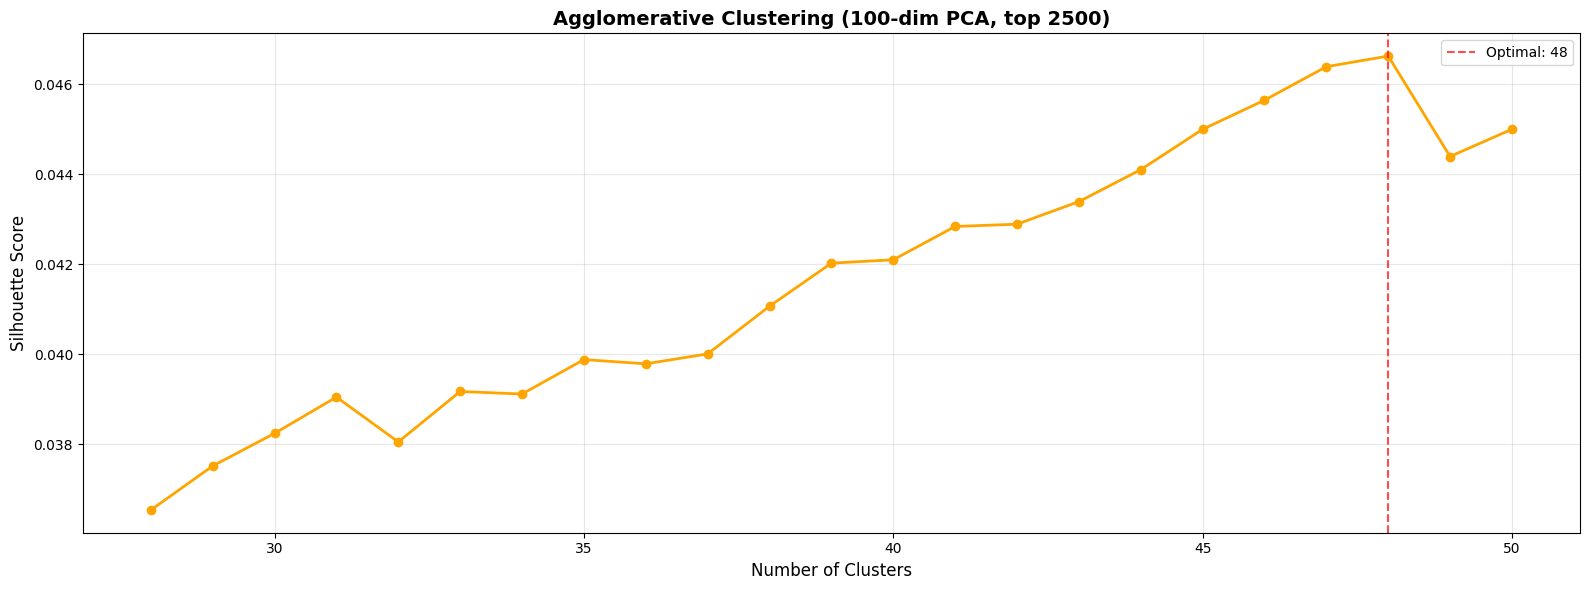

                AGGLOMERATIVE CLUSTERING (100-DIM PCA, TOP 2500)                

────────────────────────────────────────────────────────────────────────────────
Cluster  0 (size: 153)
────────────────────────────────────────────────────────────────────────────────
   1. 名单     - list                 (freq:   2212)
   2. 信息     - information          (freq:   3725)
   3. 数据     - data                 (freq:   1133)
   4. 文章     - article              (freq:   1110)
   5. 网站     - website              (freq:    823)
   6. 按钮     - button               (freq:    440)
   7. 基础     - base                 (freq:    541)
   8. 价格     - price                (freq:    639)
   9. 技术     - technology           (freq:   2136)
  10. 报道     - report               (freq:    463)
  11. 协议     - protocol             (freq:   1551)
  12. 中央     - central              (freq:    804)
  13. 现金     - cash                 (freq:   1288)
  14. 历史     - history              (freq:   2325)
  15. 资金     - fund

In [14]:
# Grid search parameters
cluster_range = range(28, 51)

# Run grid search using helper function
search_results = run_clustering_grid_search(embeddings_pca100_top2500, cluster_range, method='agglomerative')
agg_scores_2500 = search_results['agg_scores']

# Find optimal number of clusters
optimal_agg_idx_2500 = np.argmax(agg_scores_2500)
optimal_agg_clusters_2500 = list(cluster_range)[optimal_agg_idx_2500]

# Plot silhouette scores using helper function
plot_silhouette_comparison(
    cluster_range,
    {'agg': agg_scores_2500},
    {'agg': optimal_agg_clusters_2500},
    {'agg': 'Agglomerative Clustering (100-dim PCA, top 2500)'}
)

# Fit optimal model
agg_optimal_2500 = AgglomerativeClustering(n_clusters=optimal_agg_clusters_2500)
agg_optimal_labels_2500 = agg_optimal_2500.fit_predict(embeddings_pca100_top2500)

# Get top 25 words
agg_top25_2500 = find_representative_nouns(embeddings_pca100_top2500, agg_optimal_labels_2500, nouns_top2500, optimal_agg_clusters_2500, n_representatives=25, return_dict=True)

# Display results
display_clusters(agg_top25_2500, agg_optimal_labels_2500, 
                 "AGGLOMERATIVE CLUSTERING (100-DIM PCA, TOP 2500)", 
                 optimal_agg_clusters_2500)

---

A wide grid search of cluster number identified 48 as optimal. Of these, 39 clusters were coherent, and 32 of these were near-perfect. Additionally, only 37.3% of the vocabulary fell into heterogeneous clusters - the lowest across all configurations tested.

## Results

### Summary Table

| Dimensions | Words | Clusters (Agglomerative) | Coverage | Quality |
|:---:|:---:|:---:|:---:|:---:|
| Raw (768) | 500 | 15 | 40.6% | 55.6% |
| PCA (100) | 500 | 15 | 42.6% | 80.0% |
| PCA (100) | 500 | 18 | 46.6% | 75.0% |
| PCA (100) | 1000 | 18 | 38.4% | 72.7% |
| PCA (100) | 1000 | 28 | 60.5% | 78.3% |
| PCA (100) | 2500 | 28 | 53.2% | 81.0% |
| PCA (100) | 2500 | 48 | 62.5% | 82.1% |

Coverage and quality were determined through manual inspection of cluster outputs:

- **Coverage** represents the percentage of vocabulary successfully organised into semantically coherent clusters

- **Quality** measures the percentage of coherent clusters that achieved near-perfect semantic cohesion

Each vocabulary size uses its own fitted 100-dimensional PCA transformation to ensure optimal dimensionality reduction at that scale. This approach evaluates best-case clustering performance at each vocabulary level, rather than tracking cluster evolution in a fixed embedding space. 

Silhouette scores proved unreliable for PCA dimensionality selection, but were useful for cluster count selection, as geometric separation correlated well with semantic coherence in the fixed 100-dimensional space.

### Key Findings

1. BERT embeddings encode both semantic and morphological features. Single-character nouns consistently clustered together across all vocabulary sizes, whilst other groups organised by shared character components (人, 子, 色) rather than meaning.

2. A ceiling exists around 60% vocabulary coverage, regardless of parameter optimisation. This suggests that a significant portion of high-frequency Chinese nouns resist clean semantic categorisation.

3. Expanding vocabulary requires proportionally more clusters to maintain semantic coherence.

4. PCA is extremely effective for improving cluster quality.

### Recommended Configurations

`n=2500/k=48` achieved the best coverage and quality, though 48 clusters may be too granular for effective visualization.

`n=1000/k=28` offers a strong alternative, balancing good performance with more interpretable granularity.

### Save Clustering Results

In [17]:
import pickle

# Get clustering results
save_data_1000_28 = {
    'cluster_labels': agg_optimal_labels_1000,
    'embeddings_pca100': embeddings_pca100_top1000,
    'embeddings_3d': None,
    'n_clusters': optimal_agg_clusters_1000,
    'nouns_df': nouns_top1000.copy()
}
save_data_2500_48 = {
    'cluster_labels': agg_optimal_labels_2500,
    'embeddings_pca100': embeddings_pca100_top2500,
    'embeddings_3d': None,
    'n_clusters': optimal_agg_clusters_2500,
    'nouns_df': nouns_top2500.copy()
}

# Save to pickle
with open('data/noun_clustering_1000_28.pkl', 'wb') as f:
    pickle.dump(save_data_1000_28, f)

with open('data/noun_clustering_2500_48.pkl', 'wb') as f:
    pickle.dump(save_data_2500_48, f)

print(f"Clustering results saved:\nn={len(nouns_top1000)}/k={optimal_agg_clusters_1000}\nn={len(nouns_top2500)}/k={optimal_agg_clusters_2500}")

Clustering results saved:
n=1000/k=28
n=2500/k=48
